In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-paper')
import seaborn as sns
import joblib
import joypy

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import joypy
import statsmodels.api as sm

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\2916905268.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
datajh = pd.read_csv("groupedjhS.csv")
datacm = pd.read_csv("groupedcmS.csv")
datajhsoa = pd.read_csv("groupedjhSOA.csv")
datacmsoa = pd.read_csv("groupedcmSOA.csv")

In [3]:
datajhsoa["SOA"]=0
datajh["SOA"]=0
for i in datajhsoa.columns[(datajhsoa.columns.get_loc("0.25um")):(datajhsoa.columns.get_loc("0.28um"))]:
    datajhsoa["SOA"]=datajhsoa["SOA"]+datajhsoa[i]
    datajh["SOA"]=datajh["SOA"]+datajh[i]
datajhsoa["CSOA"]=0
for i in datajhsoa.columns[(datajhsoa.columns.get_loc("C0.25um")):(datajhsoa.columns.get_loc("C0.28um"))]:
    datajhsoa["CSOA"]=datajhsoa["CSOA"]+datajhsoa[i]
datacmsoa["SOA"]=0
datacm["SOA"]=0
for i in datacmsoa.columns[(datacmsoa.columns.get_loc("0.25um")):(datacmsoa.columns.get_loc("0.28um"))]:
    datacmsoa["SOA"]=datacmsoa["SOA"]+datacmsoa[i]
    datacm["SOA"]=datacm["SOA"]+datacm[i]
datacmsoa["CSOA"]=0
for i in datacmsoa.columns[(datacmsoa.columns.get_loc("C0.25um")):(datacmsoa.columns.get_loc("C0.28um"))]:
    datacmsoa["CSOA"]=datacmsoa["CSOA"]+datacmsoa[i]

In [4]:
dataj=pd.DataFrame()
datare=datajh.groupby(["Hour"]).mean().reset_index()
datak=datajh.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"]=datare["Hour"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])

#
# dataj["BVOC"]=datare.异戊二烯浓度
dataj["T"]=datare["地面层温度"]
dataj["hv"]=datare["地面层净辐射"]
dataj["RH"]=datare["地面层湿度"]
dataj["O3"]=datare.O3
dataj["NOx"]=datare.NOx
dataj["SO2"]=datare.SO2
dataj["SOA"]=datare["SOA"]
dataj["K"]=1

dataj["HNO3"]=dataj["RH"]*dataj["NOx"]
dataj["H2SO4"]=dataj["RH"]*dataj["SO2"]
dataj["H2SO403"]=dataj["RH"]*dataj["SO2"]*dataj["O3"]
dataj["HNO3O3"]=dataj["RH"]*dataj["NOx"]*dataj["O3"]
dataj["O3"]=dataj["O3"]*dataj["hv"]
dataj["hv"]=dataj["hv"]

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\531425416.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare=datajh.groupby(["Hour"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\531425416.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datak=datajh.groupby(["Hour_Min"]).mean().reset_index()


In [5]:
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest,shapiro

def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df

# Group data by hour
grouped_by_hour = datak.groupby('Hour')
normality_df=normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T']=datak.groupby('Hour').mean()["地面层温度"]

from scipy.optimize import curve_fit

# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T**2) / 2 + T * v0

# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k**2) * (T**3) )/ 3 + k * (T**2) * sigma0 + T*(sigma0**2)


# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values**2

from scipy.stats import zscore
# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值


# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]


# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered, method='trf')

BVOCs = mean_relation(normality_df['T'], *params_mean_filtered)
BVOCsV = std_dev_relation(normality_df['T'], *params_std_dev_filtered)
dataj["BVOC"] = BVOCs
dataj["BVOCsV"] = BVOCsV
dataj["BVOCsstd"] = np.sqrt(BVOCsV)
dataj["BVOCL"] = BVOCs - np.sqrt(BVOCsV)
dataj["BVOCU"] = BVOCs + np.sqrt(BVOCsV)

# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3", "K", "hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]


C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\2791458823.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  normality_df['T']=datak.groupby('Hour').mean()["地面层温度"]


In [6]:

# #删除共线变量
# dataj=dataj.drop(columns=["K_BVOC","H2SO4_BVOC"])

# 选择变量进行线性回归
weights = 1 / dataj["BVOCsV"]
X = dataj[[var + "_BVOC" for var in variables_to_regress]]  # 自变量
Y = dataj["SOA"]  # 因变量

In [7]:
# 进行线性回归
model1 = sm.WLS(Y, X, weights=weights).fit(cov_type='HC3')
# 输出结果
print(model1.summary())

                                 WLS Regression Results                                
Dep. Variable:                    SOA   R-squared (uncentered):                   0.993
Model:                            WLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              265.3
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    4.31e-16
Time:                        18:09:24   Log-Likelihood:                          25.220
No. Observations:                  24   AIC:                                     -36.44
Df Residuals:                      17   BIC:                                     -28.19
Df Model:                           7                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 创建一个DataFrame来存储VIF值
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# 计算VIF值
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,HNO3_BVOC,1.474750
1,HNO3O3_BVOC,2.566040
2,hv_BVOC,2.113276


In [8]:
dataj = pd.DataFrame()
datare = datacm.groupby(["Hour"]).mean().reset_index()
datak = datacm.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"] = datare["Hour"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])

#
# dataj["BVOC"]=datare.异戊二烯浓度
dataj["T"] = datare["地面层温度"]
dataj["hv"] = datare["地面层净辐射"]
dataj["RH"] = datare["地面层湿度"]
dataj["O3"] = datare.O3
dataj["NOx"] = datare.NOx
dataj["SO2"] = datare.SO2
dataj["SOA"] = datare["SOA"]
dataj["K"] = 1

dataj["HNO3"] = dataj["RH"] * dataj["NOx"]
dataj["H2SO4"] = dataj["RH"] * dataj["SO2"]
dataj["H2SO403"] = dataj["RH"] * dataj["SO2"] * dataj["O3"]
dataj["HNO3O3"] = dataj["RH"] * dataj["NOx"] * dataj["O3"]
dataj["O3"] = dataj["O3"] * dataj["hv"]
dataj["hv"] = dataj["hv"]
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest, shapiro


def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (
        params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df


# Group data by hour
grouped_by_hour = datak.groupby('Hour')
normality_df = normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T'] = datak.groupby('Hour').mean()["地面层温度"]

from scipy.optimize import curve_fit


# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T ** 2) / 2 + T * v0


# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k ** 2) * (T ** 3)) / 3 + k * (T ** 2) * sigma0 + T * (sigma0 ** 2)


# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2

from scipy.stats import zscore


# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值


# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]

# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered,
                                                        method='trf')
BVOCs = mean_relation(normality_df['T'], *params_mean_filtered)
BVOCsV = std_dev_relation(normality_df['T'], *params_std_dev_filtered)
dataj["BVOC"] = BVOCs
dataj["BVOCsV"] = BVOCsV
dataj["BVOCsstd"] = np.sqrt(BVOCsV)
dataj["BVOCL"] = BVOCs - np.sqrt(BVOCsV)
dataj["BVOCU"] = BVOCs + np.sqrt(BVOCsV)

# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3", "K", "hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]


C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\808838487.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare = datacm.groupby(["Hour"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\808838487.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datak = datacm.groupby(["Hour_Min"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\808838487.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should 

In [9]:
# #删除共线变量
# dataj=dataj.drop(columns=["K_BVOC","H2SO4_BVOC"])

# 选择变量进行线性回归
weights = 1 / dataj["BVOCsV"]
X = dataj[[var + "_BVOC" for var in variables_to_regress]]  # 自变量
Y = dataj["SOA"]  # 因变量

In [10]:
# 进行线性回归
model2 = sm.WLS(Y, X, weights=weights).fit(cov_type='HC3')
# 输出结果
print(model2.summary())

                                 WLS Regression Results                                
Dep. Variable:                    SOA   R-squared (uncentered):                   0.997
Model:                            WLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              876.6
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    1.79e-20
Time:                        18:09:25   Log-Likelihood:                          32.176
No. Observations:                  24   AIC:                                     -50.35
Df Residuals:                      17   BIC:                                     -42.11
Df Model:                           7                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

In [11]:
dataj = pd.DataFrame()
datare = datajh.groupby(["Hour"]).mean().reset_index()
datak = datajh.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"] = datare["Hour"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])

#
# dataj["BVOC"]=datare.异戊二烯浓度
dataj["T"] = datare["地面层温度"]
dataj["hv"] = datare["地面层净辐射"]
dataj["RH"] = datare["地面层湿度"]
dataj["O3"] = datare.O3
dataj["NOx"] = datare.NOx
dataj["SO2"] = datare.SO2
dataj["SOA"] = datare["SOA"]
dataj["K"] = 1

dataj["HNO3"] = dataj["RH"] * dataj["NOx"]
dataj["H2SO4"] = dataj["RH"] * dataj["SO2"]
dataj["H2SO403"] = dataj["RH"] * dataj["SO2"] * dataj["O3"]
dataj["HNO3O3"] = dataj["RH"] * dataj["NOx"] * dataj["O3"]
dataj["O3"] = dataj["O3"] * dataj["hv"]
dataj["hv"] = dataj["hv"]
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest, shapiro


def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (
        params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df


# Group data by hour
grouped_by_hour = datak.groupby('Hour')
normality_df = normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T'] = datak.groupby('Hour').mean()["地面层温度"]

from scipy.optimize import curve_fit


# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T ** 2) / 2 + T * v0


# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k ** 2) * (T ** 3)) / 3 + k * (T ** 2) * sigma0 + T * (sigma0 ** 2)


# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2

from scipy.stats import zscore


# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值


# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]

# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered,
                                                        method='trf')

BVOCs = mean_relation(normality_df['T'], *params_mean_filtered)
BVOCsV = std_dev_relation(normality_df['T'], *params_std_dev_filtered)
dataj["BVOC"] = BVOCs
dataj["BVOCsV"] = BVOCsV
dataj["BVOCsstd"] = np.sqrt(BVOCsV)
dataj["BVOCL"] = BVOCs - np.sqrt(BVOCsV)
dataj["BVOCU"] = BVOCs + np.sqrt(BVOCsV)

# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3", "K", "hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]

# #删除共线变量
# dataj=dataj.drop(columns=["K_BVOC","H2SO4_BVOC"])

# 选择变量进行线性回归
weights1 = 1 / dataj["BVOCsV"]
X1 = dataj[[var + "_BVOC" for var in variables_to_regress]]  # 自变量
Y1 = dataj["SOA"]  # 因变量

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731613537.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare = datajh.groupby(["Hour"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731613537.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datak = datajh.groupby(["Hour_Min"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731613537.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should 

In [12]:
dataj = pd.DataFrame()
datare = datacm.groupby(["Hour"]).mean().reset_index()
datak = datacm.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"] = datare["Hour"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])

#
# dataj["BVOC"]=datare.异戊二烯浓度
dataj["T"] = datare["地面层温度"]
dataj["hv"] = datare["地面层净辐射"]
dataj["RH"] = datare["地面层湿度"]
dataj["O3"] = datare.O3
dataj["NOx"] = datare.NOx
dataj["SO2"] = datare.SO2
dataj["SOA"] = datare["SOA"]
dataj["K"] = 1

dataj["HNO3"] = dataj["RH"] * dataj["NOx"]
dataj["H2SO4"] = dataj["RH"] * dataj["SO2"]
dataj["H2SO403"] = dataj["RH"] * dataj["SO2"] * dataj["O3"]
dataj["HNO3O3"] = dataj["RH"] * dataj["NOx"] * dataj["O3"]
dataj["O3"] = dataj["O3"] * dataj["hv"]
dataj["hv"] = dataj["hv"]
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest, shapiro


def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (
        params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df


# Group data by hour
grouped_by_hour = datak.groupby('Hour')
normality_df = normal_distribution_fit_and_test(grouped_by_hour["异戊二烯浓度"])
normality_df['T'] = datak.groupby('Hour').mean()["地面层温度"]

from scipy.optimize import curve_fit


# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T ** 2) / 2 + T * v0


# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k ** 2) * (T ** 3)) / 3 + k * (T ** 2) * sigma0 + T * (sigma0 ** 2)


# 提取数据
T = normality_df['T'].values
mean_values = normality_df['Mean'].astype("float").values
std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2

from scipy.stats import zscore


# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值


# 对 Mean 和 Standard Deviation 值应用四分位数法去除离群值
mean_values_filtered = remove_outliers(mean_values)
std_dev_values_filtered = remove_outliers(std_dev_values)

# 为过滤后的数据创建对应的 T 值数组
T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]

# 重新进行稳健拟合
params_mean_filtered, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf')
params_std_dev_filtered, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered,
                                                        method='trf')
BVOCs = mean_relation(normality_df['T'], *params_mean_filtered)
BVOCsV = std_dev_relation(normality_df['T'], *params_std_dev_filtered)
dataj["BVOC"] = BVOCs
dataj["BVOCsV"] = BVOCsV
dataj["BVOCsstd"] = np.sqrt(BVOCsV)
dataj["BVOCL"] = BVOCs - np.sqrt(BVOCsV)
dataj["BVOCU"] = BVOCs + np.sqrt(BVOCsV)

# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3", "K", "hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]
# 选择变量进行线性回归
weights2 = 1 / dataj["BVOCsV"]
X2 = dataj[[var + "_BVOC" for var in variables_to_regress]]  # 自变量
Y2 = dataj["SOA"]  # 因变量

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731317129.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare = datacm.groupby(["Hour"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731317129.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datak = datacm.groupby(["Hour_Min"]).mean().reset_index()
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\731317129.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should 

In [13]:
X=X1.append(X2)
Y=Y1.append(Y2)
weights=weights1.append(weights2)

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3609759544.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=X1.append(X2)
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3609759544.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y=Y1.append(Y2)
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3609759544.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights=weights1.append(weights2)


In [15]:
# 进行线性回归
model = sm.WLS(Y, X, weights=weights).fit(cov_type='HC3')
# 输出结果
print(model.summary())

                                 WLS Regression Results                                
Dep. Variable:                    SOA   R-squared (uncentered):                   0.983
Model:                            WLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              296.7
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    5.09e-33
Time:                        18:25:37   Log-Likelihood:                          26.074
No. Observations:                  48   AIC:                                     -38.15
Df Residuals:                      41   BIC:                                     -25.05
Df Model:                           7                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

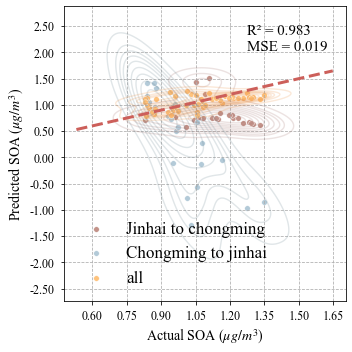

In [49]:
def predicty(model,X,Y):
    predictions=model.predict(X)
    # 计算残差
    residuals = Y - predictions
    # 计算残差的标准差
    std_dev = np.std(residuals)

    # 定义离群值的阈值，例如，超过2个标准差
    threshold = 3 * std_dev
    # 过滤掉离群值
    filtered_indices = np.abs(residuals) < threshold
    filtered_predictions = predictions[filtered_indices]
    filtered_actuals = Y[filtered_indices]
    return predictions,filtered_actuals,filtered_predictions



#金海崇明互项预测
predictions,filtered_actuals,filtered_predictions=predicty(model,X,Y)
predictions1,filtered_actuals1,filtered_predictions1=predicty(model1,X2,Y2)
predictions2,filtered_actuals2,filtered_predictions2=predicty(model2,X1,Y1)


# 计算R²和MSE
r2 = model.rsquared
mse = mean_squared_error(Y, predictions)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(y=filtered_predictions1,x=filtered_actuals1,label="Jinhai to chongming",color="#C39289",ax=ax)
sns.scatterplot(y=filtered_predictions2,x=filtered_actuals2,label="Chongming to jinhai",color="#B3CAD8",ax=ax)
sns.scatterplot(y=filtered_predictions,x=filtered_actuals,label="all",color="#FEC37D",ax=ax)
sns.kdeplot(y=filtered_predictions1,x=filtered_actuals1, color="#A1706B",fill=False, alpha=0.2,ax=ax)
sns.kdeplot(y=filtered_predictions2,x=filtered_actuals2, color="#66828E",fill=False, alpha=0.2,ax=ax)
sns.kdeplot(y=filtered_predictions,x=filtered_actuals, color="#EC8F3F",fill=False, alpha=0.2,ax=ax)


all_values = np.concatenate([filtered_actuals1, filtered_actuals2])
min_val = all_values.min()
max_val = all_values.max()
# ax.plot([min(filtered_actuals), max(filtered_actuals)], [min(filtered_actuals), max(filtered_actuals)], color='#CC5F5A', linestyle='--',linewidth=3)
# 绘制等值线，确保它覆盖整个图表的范围
n=0.3
ax.plot([min_val-n, max_val+n], [min_val-n, max_val+n], color='#CC5F5A', linestyle='--', linewidth=3)


ax.set_ylabel('Predicted SOA ($μg/m^3$)', fontsize=14)
ax.set_xlabel('Actual SOA ($μg/m^3$)', fontsize=14)
ax.text(0.65,0.85, f'R² = {r2:.3f}\nMSE = {mse:.3f}', fontsize=15, color='black', transform=ax.transAxes)

# # 设置坐标轴范围
# ax.set_xlim(filtered_predictions.min(), filtered_predictions.max())
# ax.set_ylim(filtered_actuals.min(), filtered_actuals.max())



def format_ticks(x, pos):
    return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
# 设置x轴刻度的格式
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
ax.tick_params(axis='both', labelsize=12)

ax.grid(linestyle='--')
ax.legend(title='', frameon=False, loc="lower left", fontsize=17)

# 显示图形
plt.tight_layout()
plt.savefig("金海崇明互预测.svg", bbox_inches='tight')
plt.show()

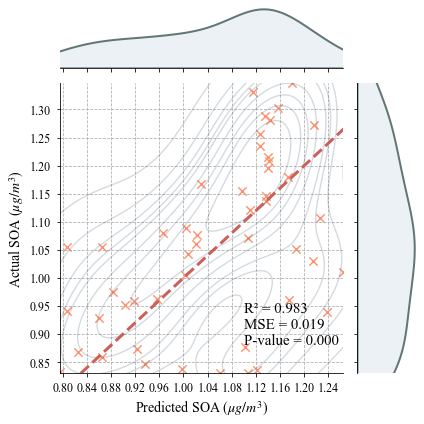

In [110]:
model1=model

predictions=model1.predict(X)
# 计算残差
residuals = Y - predictions

# 计算残差的标准差
std_dev = np.std(residuals)

# 定义离群值的阈值，例如，超过2个标准差
threshold = 3 * std_dev

# 过滤掉离群值
filtered_indices = np.abs(residuals) < threshold
filtered_predictions = predictions[filtered_indices]
filtered_actuals = Y[filtered_indices]


# 计算R²和MSE
r2 = model1.rsquared
pvalue=model1.f_pvalue
mse = mean_squared_error(Y, predictions)


# 创建JointGrid对象
g = sns.JointGrid(x=filtered_predictions, y=filtered_actuals, space=0, ratio=4, height=6)


# 在边缘绘制KDE
g = g.plot_marginals(sns.kdeplot, color="#B3CAD8", fill=True, edgecolor="#627676",linewidth=2)

# 在中心绘制散点图
g = g.plot_joint(plt.scatter, color="#FD9270",marker='x',s=70)

# 密度图
g = g.plot_joint(sns.kdeplot, color="#2A4C65",fill=False, alpha=0.2)

# 绘制 y = x 线表示理想情况
g.ax_joint.plot([min(filtered_actuals), max(filtered_actuals)], [min(filtered_actuals), max(filtered_actuals)], color='#CC5F5A', linestyle='--',linewidth=3)

# 添加标题、轴标签和文本
plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Predicted vs Actual Values', fontsize=14)
g.ax_joint.set_xlabel('Predicted SOA ($μg/m^3$)', fontsize=14)
g.ax_joint.set_ylabel('Actual SOA ($μg/m^3$)', fontsize=14)
g.ax_joint.text(0.65,0.1, f'R² = {r2:.3f}\nMSE = {mse:.3f}\nP-value = {pvalue:.3f}', fontsize=15, color='black', transform=g.ax_joint.transAxes)

# 设置坐标轴范围
g.ax_joint.set_xlim(filtered_predictions.min(), filtered_predictions.max())
g.ax_joint.set_ylim(filtered_actuals.min(), filtered_actuals.max())



def format_ticks(x, pos):
    return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
# 设置x轴刻度的格式
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(format_ticks))
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(format_ticks))
g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=12))
g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=12))
g.ax_joint.tick_params(axis='both', labelsize=12)

g.ax_joint.grid(linestyle='--')
# 显示图形
plt.tight_layout()
plt.savefig("总预测Hour.svg", bbox_inches='tight')
plt.show()

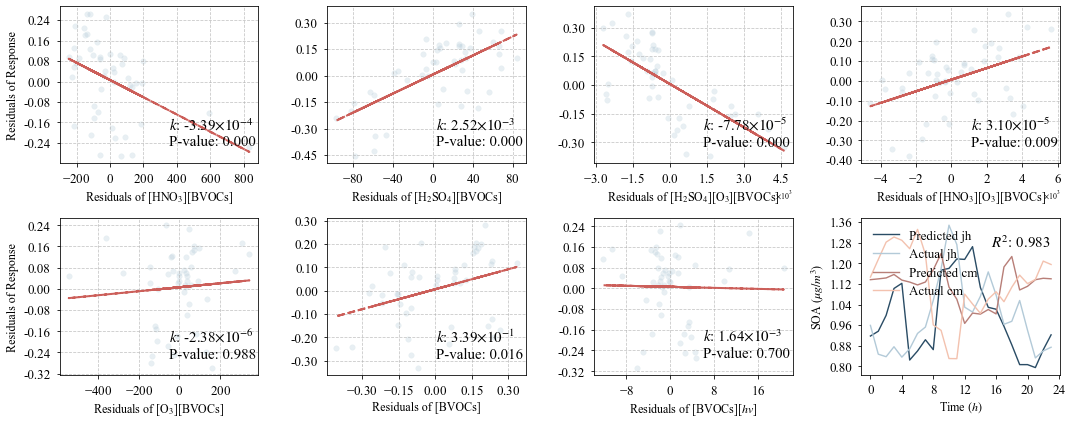

In [116]:
variablename=['[HNO$_3$][BVOCs]',
 '[H$_2$SO$_4$][BVOCs]',
 '[H$_2$SO$_4$][O$_3$][BVOCs]',
 '[HNO$_3$][O$_3$][BVOCs]',
 '[O$_3$][BVOCs]',
 '[BVOCs]',
 '[BVOCs][$hv$]']


model=model1

# 创建一个2行4列的图形
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# 获取模型的系数和p值
coefficients = model.params
p_values = model.pvalues

# 函数将数字转换为乘方形式
def sci_notation(num, decimal_digits=2):
    if num != 0:
        exponent = np.floor(np.log10(np.abs(num)))
        mantissa = num / 10**exponent

        return f"{mantissa:.{decimal_digits}f}"+"$×10^"+"{"+str(int(exponent))+"}$"
    else:
        return "0"


# 遍历所有变量，绘制部分回归图
for i, variable in enumerate(model.model.exog_names):
    ax = axs[i // 4, i % 4] # 确定子图的位置
    variable_idx = model.model.exog_names.index(variable)

    # 创建局部变量用于部分回归图的绘制
    X_local = np.delete(model.model.exog, variable_idx, axis=1)
    Y_local = model.model.endog

    # 拟合没有选择变量的模型
    model_without_variable = sm.OLS(Y_local, X_local).fit(cov_type='HC3')
    residuals_Y = Y_local - model_without_variable.predict(X_local)

    # 计算选择变量的残差
    model_for_variable = sm.OLS(model.model.exog[:, variable_idx], X_local).fit()
    residuals_X = model.model.exog[:, variable_idx] - model_for_variable.predict(X_local)

    # 绘制部分回归图
    ax.scatter(residuals_X, residuals_Y,color="#B3CAD8", alpha=0.3,marker='o')
    ax.set_xlabel(f'Residuals of {variablename[i]}', fontsize=12)
    if i==0 or i==4:
        ax.set_ylabel('Residuals of Response', fontsize=12)
    # ax.set_title(f'Partial Regression Plot for {variable}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # 标注系数和显著性
    coef = coefficients[variable_idx]
    p_value = p_values[variable_idx]

    coef = sci_notation(coefficients[variable_idx])
    ax.text(0.55, 0.3, f'$k$: {coef}\nP-value: {p_value:.3f}', transform=ax.transAxes, verticalalignment='top', fontsize=15)

    # 添加拟合线
    reg_line = sm.OLS(residuals_Y, sm.add_constant(residuals_X)).fit().fittedvalues
    ax.plot(residuals_X, reg_line, color='#CC5F5A', linestyle='--',linewidth=2)

    def format_ticks(x, pos):
        return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改

    # 设置x轴刻度的格式为科学计数法
    formatter = ScalarFormatter(useOffset=True, useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))  # 可以根据您的数据范围调整这里的参数


    # 设置x轴刻度的格式
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.xaxis.set_major_formatter(formatter)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.tick_params(axis='both', labelsize=13)


predictions1=model.predict(X1)
predictions2=model.predict(X2)
ax=  axs[1][3]
sns.lineplot(x=datare["Hour"],y=predictions1, label='Predicted jh',ax=ax,color="#2A4C65")
sns.lineplot(x=datare["Hour"],y=Y1, label='Actual jh',ax=ax,color="#B3CAD8")

sns.lineplot(x=datare["Hour"],y=predictions2, label='Predicted cm',ax=ax,color="#B87F78")
sns.lineplot(x=datare["Hour"],y=Y2, label='Actual cm',ax=ax,color="#F3C2AF")
ax.set_xlabel('Time $(h)$', fontsize=12)
ax.set_ylabel('SOA ($μg/m^3$)', fontsize=12)

import matplotlib.dates as mdates
ax.tick_params(axis='both', labelsize=13)

# 设置x轴刻度的格式
ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.legend(title='', frameon=False, loc="upper left", fontsize=13)
r2 = model.rsquared
ax.text(0.65, 0.9, f'$R^2$: {r2:.3f}', transform=ax.transAxes, verticalalignment='top', fontsize=15)


# # 移除最后一个空白的子图
# fig.delaxes(axs[1][3])

# 调整子图布局
plt.tight_layout()

plt.savefig("总预测Hour 系数.svg", bbox_inches='tight')
plt.savefig("总预测Hour 系数.jpg", bbox_inches='tight',dpi=1000)
# 显示图形
plt.show()

In [117]:
dataj=pd.DataFrame()
datare=datajh.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"]=datare["Hour_Min"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])


dataj["BVOC"]=datare.异戊二烯浓度
# dataj["BVOC"]=datare['异戊二烯浓度']+datare["1,3-丁二烯浓度"]+datare["戊烯浓度"]+datare["丁烯浓度"]
dataj["T"]=datare["地面层温度"]
dataj["hv"]=datare["地面层净辐射"]
dataj["RH"]=datare["地面层湿度"]
dataj["O3"]=datare.O3
dataj["NOx"]=datare.NOx
dataj["SO2"]=datare.SO2
dataj["SOA"]=0
for i in datare.columns[(datare.columns.get_loc("0.25um")):(datare.columns.get_loc("0.28um"))]:
    dataj["SOA"]=dataj["SOA"]+datare[i]
dataj["K"]=1

dataj["HNO3"]=dataj["RH"]*dataj["NOx"]
dataj["H2SO4"]=dataj["RH"]*dataj["SO2"]
dataj["H2SO403"]=dataj["RH"]*dataj["SO2"]*dataj["O3"]
dataj["HNO3O3"]=dataj["RH"]*dataj["NOx"]*dataj["O3"]
dataj["O3"]=dataj["O3"]*dataj["hv"]
dataj["hv"]=dataj["hv"]
# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3","K","hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]

# 选择变量进行线性回归
X1 = dataj[[var + "_BVOC" for var in variables_to_regress]] # 自变量
Y1 = dataj["SOA"] # 因变量

C:\Users\aa271\AppData\Local\Temp\ipykernel_37712\3525985924.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare=datajh.groupby(["Hour_Min"]).mean().reset_index()


In [118]:
dataj=pd.DataFrame()
datare=datacm.groupby(["Hour_Min"]).mean().reset_index()

dataj["Time"]=datare["Hour_Min"]
# 转换时间数据
dataj['Time'] = pd.to_datetime(dataj['Time'])


dataj["BVOC"]=datare.异戊二烯浓度
# dataj["BVOC"]=datare['异戊二烯浓度']+datare["1,3-丁二烯浓度"]+datare["戊烯浓度"]+datare["丁烯浓度"]
dataj["T"]=datare["地面层温度"]
dataj["hv"]=datare["地面层净辐射"]
dataj["RH"]=datare["地面层湿度"]
dataj["O3"]=datare.O3
dataj["NOx"]=datare.NOx
dataj["SO2"]=datare.SO2
dataj["SOA"]=0
for i in datare.columns[(datare.columns.get_loc("0.25um")):(datare.columns.get_loc("0.28um"))]:
    dataj["SOA"]=dataj["SOA"]+datare[i]
dataj["K"]=1

dataj["HNO3"]=dataj["RH"]*dataj["NOx"]
dataj["H2SO4"]=dataj["RH"]*dataj["SO2"]
dataj["H2SO403"]=dataj["RH"]*dataj["SO2"]*dataj["O3"]
dataj["HNO3O3"]=dataj["RH"]*dataj["NOx"]*dataj["O3"]
dataj["O3"]=dataj["O3"]*dataj["hv"]
dataj["hv"]=dataj["hv"]
# 将这些变量乘以 BVOC
variables_to_regress = ["HNO3", "H2SO4", "H2SO403", "HNO3O3", "O3","K","hv"]
for var in variables_to_regress:
    dataj[var + "_BVOC"] = dataj[var] * dataj["BVOC"]

# 选择变量进行线性回归
X2 = dataj[[var + "_BVOC" for var in variables_to_regress]] # 自变量
Y2 = dataj["SOA"] # 因变量

C:\Users\aa271\AppData\Local\Temp\ipykernel_37712\3436375466.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datare=datacm.groupby(["Hour_Min"]).mean().reset_index()


In [50]:
X=X1.append(X2)
Y=Y1.append(Y2)
weights=weights1.append(weights2)
# 进行线性回归
model = sm.OLS(Y, X).fit(cov_type='HC3')
# 输出结果
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SOA   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              302.5
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    3.45e-33
Time:                        19:22:27   Log-Likelihood:                          26.745
No. Observations:                  48   AIC:                                     -39.49
Df Residuals:                      41   BIC:                                     -26.39
Df Model:                           7                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3381435854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X=X1.append(X2)
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3381435854.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y=Y1.append(Y2)
C:\Users\aa271\AppData\Local\Temp\ipykernel_19024\3381435854.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights=weights1.append(weights2)


In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 创建一个DataFrame来存储VIF值
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# 计算VIF值
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,HNO3_BVOC,20.848824
1,H2SO4_BVOC,86.375724
2,H2SO403_BVOC,37.563198
3,HNO3O3_BVOC,47.178418
4,O3_BVOC,56.296522
5,K_BVOC,65.684840
6,hv_BVOC,52.550207


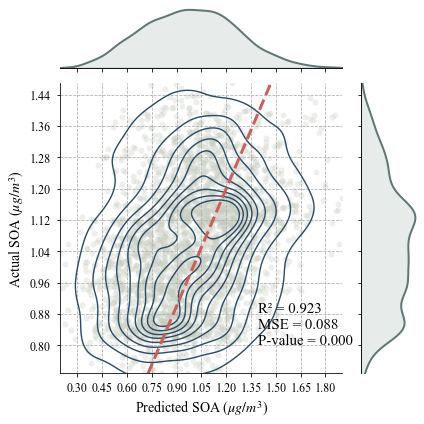

In [120]:
predictions=model.predict(X)
# 计算残差
residuals = Y - predictions

# 计算残差的标准差
std_dev = np.std(residuals)

# 定义离群值的阈值，例如，超过2个标准差
threshold = 3 * std_dev

# 过滤掉离群值
filtered_indices = np.abs(residuals) < threshold
filtered_predictions = predictions[filtered_indices]
filtered_actuals = Y[filtered_indices]


# 计算R²和MSE
r2 = model.rsquared
pvalue=model.f_pvalue
mse = mean_squared_error(Y, predictions)


# 创建JointGrid对象
g = sns.JointGrid(x=filtered_predictions, y=filtered_actuals, space=0, ratio=4, height=6)


# 在边缘绘制KDE
g = g.plot_marginals(sns.kdeplot, color="#A1B0AD", fill=True, edgecolor="#627676",linewidth=2)

# 在中心绘制散点图
g = g.plot_joint(plt.scatter, color="#C6CCC0", alpha=0.3,marker='o')

# 密度图
g = g.plot_joint(sns.kdeplot, color="#2A4C65",fill=False)

# 绘制 y = x 线表示理想情况
g.ax_joint.plot([min(filtered_actuals), max(filtered_actuals)], [min(filtered_actuals), max(filtered_actuals)], color='#CC5F5A', linestyle='--',linewidth=3)

# 添加标题、轴标签和文本
plt.subplots_adjust(top=0.9)
# g.fig.suptitle('Predicted vs Actual Values', fontsize=14)
g.ax_joint.set_xlabel('Predicted SOA ($μg/m^3$)', fontsize=14)
g.ax_joint.set_ylabel('Actual SOA ($μg/m^3$)', fontsize=14)
g.ax_joint.text(0.7,0.1, f'R² = {r2:.3f}\nMSE = {mse:.3f}\nP-value = {pvalue:.3f}', fontsize=15, color='black', transform=g.ax_joint.transAxes)

# 设置坐标轴范围
g.ax_joint.set_xlim(filtered_predictions.min(), filtered_predictions.max())
g.ax_joint.set_ylim(filtered_actuals.min(), filtered_actuals.max())



def format_ticks(x, pos):
    return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
# 设置x轴刻度的格式
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(format_ticks))
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(format_ticks))
g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=12))
g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=12))
g.ax_joint.tick_params(axis='both', labelsize=12)

g.ax_joint.grid(linestyle='--')

# 显示图形
plt.tight_layout()
plt.savefig("SOA 总预测.svg", bbox_inches='tight')
plt.show()

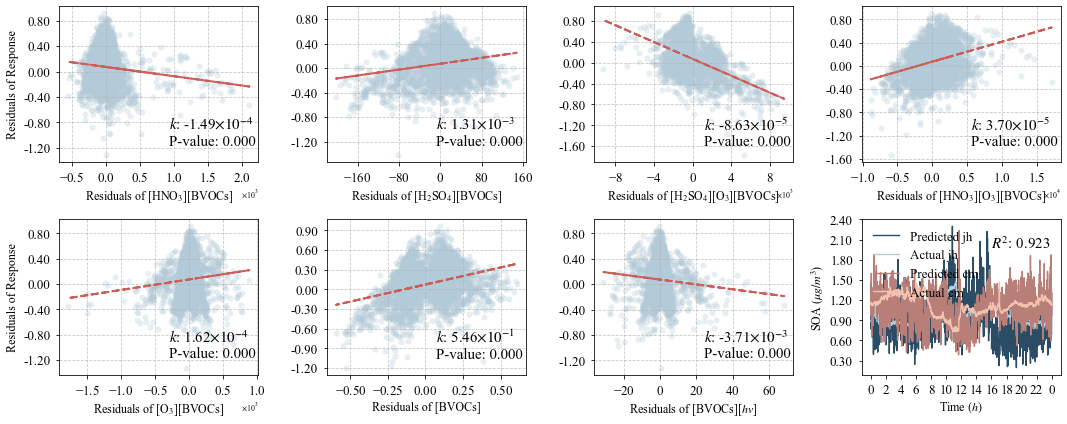

In [121]:
# 创建一个2行4列的图形
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# 获取模型的系数和p值
coefficients = model.params
p_values = model.pvalues

# 函数将数字转换为乘方形式
def sci_notation(num, decimal_digits=2):
    if num != 0:
        exponent = np.floor(np.log10(np.abs(num)))
        mantissa = num / 10**exponent

        return f"{mantissa:.{decimal_digits}f}"+"$×10^"+"{"+str(int(exponent))+"}$"
    else:
        return "0"


# 遍历所有变量，绘制部分回归图
for i, variable in enumerate(model.model.exog_names):
    ax = axs[i // 4, i % 4] # 确定子图的位置
    variable_idx = model.model.exog_names.index(variable)

    # 创建局部变量用于部分回归图的绘制
    X_local = np.delete(model.model.exog, variable_idx, axis=1)
    Y_local = model.model.endog

    # 拟合没有选择变量的模型
    model_without_variable = sm.OLS(Y_local, X_local).fit(cov_type='HC3')
    residuals_Y = Y_local - model_without_variable.predict(X_local)

    # 计算选择变量的残差
    model_for_variable = sm.OLS(model.model.exog[:, variable_idx], X_local).fit()
    residuals_X = model.model.exog[:, variable_idx] - model_for_variable.predict(X_local)

    # 绘制部分回归图
    ax.scatter(residuals_X, residuals_Y,color="#B3CAD8", alpha=0.3,marker='o')
    ax.set_xlabel(f'Residuals of {variablename[i]}', fontsize=12)
    if i==0 or i==4:
        ax.set_ylabel('Residuals of Response', fontsize=12)
    # ax.set_title(f'Partial Regression Plot for {variable}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # 标注系数和显著性
    coef = coefficients[variable_idx]
    p_value = p_values[variable_idx]

    coef = sci_notation(coefficients[variable_idx])
    ax.text(0.55, 0.3, f'$k$: {coef}\nP-value: {p_value:.3f}', transform=ax.transAxes, verticalalignment='top', fontsize=15)

    # 添加拟合线
    reg_line = sm.OLS(residuals_Y, sm.add_constant(residuals_X)).fit().fittedvalues
    ax.plot(residuals_X, reg_line, color='#CC5F5A', linestyle='--',linewidth=2)

    def format_ticks(x, pos):
        return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改

    # 设置x轴刻度的格式为科学计数法
    formatter = ScalarFormatter(useOffset=True, useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))  # 可以根据您的数据范围调整这里的参数


    # 设置x轴刻度的格式
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.xaxis.set_major_formatter(formatter)

    ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.tick_params(axis='both', labelsize=13)



predictions1=model.predict(X1)
predictions2=model.predict(X2)
ax=  axs[1][3]
sns.lineplot(x=dataj.Time,y=predictions1, label='Predicted jh',ax=ax,color="#2A4C65")
sns.lineplot(x=dataj.Time,y=Y1, label='Actual jh',ax=ax,color="#B3CAD8")

sns.lineplot(x=dataj.Time,y=predictions2, label='Predicted cm',ax=ax,color="#B87F78")
sns.lineplot(x=dataj.Time,y=Y2, label='Actual cm',ax=ax,color="#F3C2AF")
ax.set_xlabel('Time $(h)$', fontsize=12)
ax.set_ylabel('SOA ($μg/m^3$)', fontsize=12)

import matplotlib.dates as mdates
ax.tick_params(axis='both', labelsize=13)

# 自定义格式化函数
def custom_hour_formatter(x, pos):
    dt = mdates.num2date(x)
    hour = dt.strftime('%H')
    # 如果小时小于10，则去除前导零
    if hour.startswith('0'):
        hour = hour[1:]
    return hour if dt.minute == 0 else ''

ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_hour_formatter))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.legend(title='', frameon=False, loc="upper left", fontsize=13)
r2 = model.rsquared
ax.text(0.65, 0.9, f'$R^2$: {r2:.3f}', transform=ax.transAxes, verticalalignment='top', fontsize=15)


# # 移除最后一个空白的子图
# fig.delaxes(axs[1][3])

# 调整子图布局
plt.tight_layout()

plt.savefig("总预测 系数.svg", bbox_inches='tight')
plt.savefig("总预测 系数.jpg", bbox_inches='tight',dpi=1000)
# 显示图形
plt.show()